In [1]:
import torch
import scipy
import numpy as np

In [2]:
# load /vol/bitbucket/dm2223/info-theory-experiments/data/ecog_data_raw/Motion.mat

file_path = '/vol/bitbucket/dm2223/info-theory-experiments/data/ecog_data_raw/Motion.mat'

# Load the MATLAB file
mat_data = scipy.io.loadmat(file_path)

motion_time = torch.from_numpy(np.asarray(mat_data['MotionTime'])).squeeze()[1:]

print(motion_time.size())

torch.Size([125373])


In [3]:
ecog_time_path = "/vol/bitbucket/dm2223/info-theory-experiments/data/ecog_data_raw/ECoG_time.mat"

# Load the MATLAB file with ECoGTime key
mat_data = scipy.io.loadmat(ecog_time_path)
ecog_time_1000 = torch.from_numpy(np.asarray(mat_data['ECoGTime'])).squeeze()

# downsmaple

ecog_time_300 = ecog_time_1000[::3]


In [4]:
print(ecog_time_1000[-10:])
print(ecog_time_300[-10:])

tensor([1045.8190, 1045.8200, 1045.8210, 1045.8220, 1045.8230, 1045.8240,
        1045.8250, 1045.8260, 1045.8270, 1045.8280], dtype=torch.float64)
tensor([1045.8010, 1045.8040, 1045.8070, 1045.8100, 1045.8130, 1045.8160,
        1045.8190, 1045.8220, 1045.8250, 1045.8280], dtype=torch.float64)


In [5]:
num_motion_timesteps = motion_time.size(0)

print(num_motion_timesteps)

indices = []
for t in motion_time:
    differences = torch.abs((ecog_time_300 - t))
    index = torch.argmin(differences)
    indices.append(index.item())


125373


In [6]:

print(len(motion_time))

print(len(indices))

print(len(ecog_time_300[indices]))

125373
125373
125373


In [7]:
from models import SkipConnectionSupervenientFeatureNetwork

seed = 1

torch.manual_seed(seed)

device = "cuda"

config = {
    "torch_seed": seed,
    "dataset_type": "ecog",
    "num_atoms": 64,
    "batch_size": 1000,
    "train_mode": True,
    "train_model_B": False,
    "adjust_Psi": False,
    "clip": 5,
    "feature_size": 3,
    "epochs": 70,
    "start_updating_f_after": 500,
    "update_f_every_N_steps": 5,
    "minimize_neg_terms_until": 9999999999,
    "downward_critics_config": {
        "hidden_sizes_v_critic": [512, 1024, 1024, 512],
        "hidden_sizes_xi_critic": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    "decoupled_critic_config": {
        "hidden_sizes_encoder_1": [512, 512, 512],
        "hidden_sizes_encoder_2": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    "feature_network_config": {
        "hidden_sizes": [256, 256, 256, 256, 256],
        "lr": 1e-4,
        "bias": True,
        "weight_decay": 1e-3,
    }
}

model_path = "/vol/bitbucket/dm2223/info-theory-experiments/models/ECOG_feature_network_devout-leaf-5.pth"


skip_model = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_network_config']['hidden_sizes'],
    include_bias=config['feature_network_config']['bias'],
).to(device)


skip_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [8]:

from datasets import ECoGDataset

dataset = ECoGDataset(prepare_pairs=False)

In [9]:
file_path = '/vol/bitbucket/dm2223/info-theory-experiments/data/ecog_data_raw/Motion.mat'

# Load the MATLAB file
mat_data = scipy.io.loadmat(file_path)

print(mat_data['MotionData'][0][0].shape)
print(mat_data['MotionData'][1][0].shape)
print(mat_data['MotionData'][2][0].shape)
print(mat_data['MotionData'][3][0].shape)
print(mat_data['MotionData'][4][0].shape)
print(mat_data['MotionData'][5][0].shape)


(125374, 3)
(125374, 3)
(125374, 3)
(125374, 3)
(125374, 3)
(125374, 3)


In [10]:
# clear cache
import torch
torch.cuda.empty_cache()

In [15]:
device = 'cuda'

downsampled_dataset = dataset[indices].to(device).float()

j = 5

body_part = torch.tensor(mat_data['MotionData'][j][0])[1:]



model_path = "/vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_earthy-sun-6.pth"


skip_model = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_network_config']['hidden_sizes'],
    include_bias=config['feature_network_config']['bias'],
).to(device)


skip_model.load_state_dict(torch.load(model_path))


V = skip_model(downsampled_dataset)


OutOfMemoryError: CUDA out of memory. Tried to allocate 124.00 MiB. GPU 

In [12]:
# make a dataset clas with V as the x and left_wrist as the y

import torch
from torch.utils.data import Dataset, DataLoader

class MotionDataset(Dataset):
    def __init__(self, x_data, y_data):
        """
        Args:
            x_data (torch.Tensor): The input features - V
            y_data (torch.Tensor): The target labels - left_wrist
        """
        self.x_data = x_data.detach()
        self.y_data = y_data.detach()

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y



Epoch [1/50], Step [100], Loss: 2684.763671875
Epoch [2/50], Step [200], Loss: 2589.587158203125
Epoch [3/50], Step [300], Loss: 2727.927001953125
Epoch [4/50], Step [400], Loss: 2849.98388671875
Epoch [4/50], Step [500], Loss: 2575.15771484375
Epoch [5/50], Step [600], Loss: 2636.1025390625
Epoch [6/50], Step [700], Loss: 2743.47119140625
Epoch [7/50], Step [800], Loss: 2554.658203125
Epoch [8/50], Step [900], Loss: 2550.374267578125
Epoch [8/50], Step [1000], Loss: 2501.752197265625
Epoch [9/50], Step [1100], Loss: 3055.841552734375
Epoch [10/50], Step [1200], Loss: 2381.890625
Epoch [11/50], Step [1300], Loss: 2397.886962890625
Epoch [12/50], Step [1400], Loss: 2444.318359375
Epoch [12/50], Step [1500], Loss: 2521.951416015625
Epoch [13/50], Step [1600], Loss: 2362.15625
Epoch [14/50], Step [1700], Loss: 2210.107666015625
Epoch [15/50], Step [1800], Loss: 2523.06494140625
Epoch [16/50], Step [1900], Loss: 2283.369384765625
Epoch [16/50], Step [2000], Loss: 2410.35791015625
Epoch [17

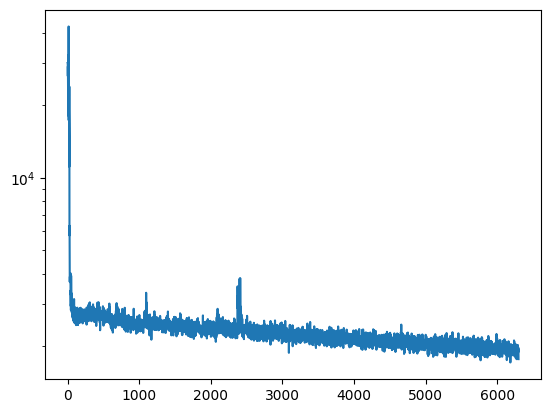

In [13]:

motion_dataset = MotionDataset(V, body_part)


dataloader = DataLoader(motion_dataset, batch_size=1000, shuffle=True)


class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(64, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1024)
        self.fc4 = torch.nn.Linear(1024, 2048)
        self.fc5 = torch.nn.Linear(2048, 2048)
        self.fc6 = torch.nn.Linear(2048, 3)
        
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

mlp = MLP().to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
losses = []
for epoch in range(num_epochs):
    for batch in dataloader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(x).to(device)

        
        # Compute loss
        loss = criterion(outputs, y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # print loss every 100 steps
        if len(losses) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{len(losses)}], Loss: {loss.item()}')


import matplotlib.pyplot as plt
print(min(losses))
plt.plot(losses)
plt.yscale('log')

plt.show()    

1633.7039794921875


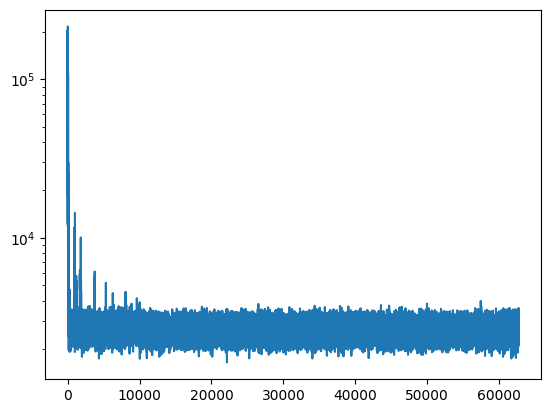

In [14]:


# shuffle left wrist
random_indices = torch.randperm(body_part.size(0))

left_wrist_shuffled = body_part[random_indices]

# assert different

motion_dataset = MotionDataset(downsampled_dataset, left_wrist_shuffled)


dataloader = DataLoader(motion_dataset, batch_size=100, shuffle=True)


class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(64, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1024)
        self.fc4 = torch.nn.Linear(1024, 2048)
        self.fc5 = torch.nn.Linear(2048, 2048)
        self.fc6 = torch.nn.Linear(2048, 3)
        
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

mlp = MLP().to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
losses = []
for epoch in range(num_epochs):
    for batch in dataloader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(x).to(device)

        
        # Compute loss
        loss = criterion(outputs, y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


import matplotlib.pyplot as plt

print(min(losses))
plt.plot(losses)
plt.yscale('log')

plt.show()    